# Identifying people using gait recognition

In [2]:
#IPython is what you are using now to run the notebook
import IPython
print "IPython version:      %6.6s (need at least 1.0)" % IPython.__version__

# Numpy is a library for working with Arrays
import numpy as np
print "Numpy version:        %6.6s (need at least 1.7.1)" % np.__version__

# SciPy implements many different numerical algorithms
import scipy as sp
print "SciPy version:        %6.6s (need at least 0.12.0)" % sp.__version__

# Pandas makes working with data tables easier
import pandas as pd
print "Pandas version:       %6.6s (need at least 0.11.0)" % pd.__version__

# Module for plotting
import matplotlib
print "Mapltolib version:    %6.6s (need at least 1.2.1)" % matplotlib.__version__

# SciKit Learn implements several Machine Learning algorithms
import sklearn
print "Scikit-Learn version: %6.6s (need at least 0.13.1)" % sklearn.__version__

%pylab inline
%matplotlib inline  
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

#peak finder
import peakutils #external library for peak detection

IPython version:       4.0.3 (need at least 1.0)
Numpy version:        1.10.2 (need at least 1.7.1)
SciPy version:        0.16.1 (need at least 0.12.0)
Pandas version:       0.17.1 (need at least 0.11.0)
Mapltolib version:     1.5.1 (need at least 1.2.1)
Scikit-Learn version:   0.17 (need at least 0.13.1)
Populating the interactive namespace from numpy and matplotlib


## Read in accelerometer data

In [3]:
#read in csv files
sampling_freq = 32.0
acc_1 = np.genfromtxt('1_ACC.csv', delimiter=',') 
acc_2 = np.genfromtxt('2_ACC.csv', delimiter=',') 
acc_3 = np.genfromtxt('3_ACC.csv', delimiter=',') 
acc_4 = np.genfromtxt('4_ACC.csv', delimiter=',') 
acc_5 = np.genfromtxt('5_ACC.csv', delimiter=',') 
acc_6 = np.genfromtxt('6_ACC.csv', delimiter=',') 
acc_7 = np.genfromtxt('7_ACC.csv', delimiter=',')
num_data = 7

## Functions to process the data

In [7]:
# find the magnitude of the acceleration
def findmag(acc): 
    mag = []
    for x,y,z in zip(acc[:,0],acc[:,1],acc[:,2]):
        mag.append(np.sqrt(x**2+y**2+z**2))
        
    return mag

In [8]:
# plot the acceleration
def plotacc(mag):
    plt.figure(figsize=[10,7])
    t = np.linspace(0,len(mag)/sampling_freq, len(mag))
    plt.plot(t,mag)
    plt.ylabel('acceleration magnitude')
    plt.xlabel('time (sec)')
    plt.show()

In [9]:
# find the indexes of the peaks
def findpeaks(mag,threshold=0.28,dist=20,plot=False):
    
    mag = mag - np.mean(mag)

    t = np.linspace(0,1.0*len(mag)/sampling_freq, len(mag))
    indexes = peakutils.peak.indexes(mag, thres=threshold, min_dist=dist)
    if plot == True:
        plt.figure(figsize=[12,2])
        plt.plot(t,mag)
        plt.scatter(1.0*indexes/sampling_freq,mag[indexes],color='r')
        plt.xlabel('time')
        plt.ylabel('acceleration magnitude')
    return indexes

In [10]:
# use the indexes to align the steps
def alignsteps(indexes,mag,plot=False):
    buffersize = 20
    j = 0
    t = np.linspace(0,41.0/sampling_freq,41)
    length_ind = 0
    
    # to make sure there are 20 data points before and after the peak
    for i in indexes:
        tmp = mag[i-buffersize:i+buffersize+1]
        if size(tmp) == buffersize*2+1:
            length_ind += 1
    steps = np.zeros([length_ind,buffersize*2+1])
    
    if plot == True:
        plt.figure(figsize=[12,2])
    
    # extracting out the steps
    for i in indexes:
        tmp = mag[i-buffersize:i+buffersize+1]
        if size(tmp) == buffersize*2+1:
            steps[j,:] = tmp
            j = j + 1
            if plot == True:
                plt.plot(t,tmp)
        
    # plot the mean
    mean_steps = np.array([np.mean(steps,axis=0)]).T
    if plot == True:
        plt.plot(t,mean_steps,color='r',linewidth=5)
        plt.xlabel('time')
        plt.ylabel('acceleration magnitude')
        
    return steps, mean_steps

In [11]:
# find the eigenvalues and eigenvectors of the covariance matrix
def dopca(steps,mean_steps,plot=False, numeigen=18):
    
    #41 samples per step
    C = np.cov(steps.T) #find the covariance matrix
    D, U = np.linalg.eig(C) # eigen decomposition
    
    # plot the reconstructed first step
    if plot==True:
        W = U[:,0:numeigen].T 
        Y = np.dot(W,(steps.T - np.tile(mean_steps,(1,len(steps)))))
        Y1 = np.array(Y[:,0])    
        Xr1 = np.array([np.dot(W.T,Y1)]).T + mean_steps
        plt.figure(figsize=[12,5])
        plt.plot(t,steps.T[:,0],'b', label='original step 1') #full data representation of step 1
        plt.plot(t,Xr1,'r', label='PCA reconstruction of step 1') #PCA representation of step 1
        plt.xlabel('time')
        plt.ylabel('acceleration magnitude')
        plt.legend(loc='upper left')
        plt.show()

    return D,U

In [12]:
# find the cumulative sum of the eigenvalues
def cumulativeEigen(D,plot=False):
    plt.figure(figsize=[12,5])
    x = np.linspace(1,41,41)
    D_norm = D / np.sum(D)
    cumulative = np.cumsum(D_norm)
    plt.plot(x,cumulative)
    plt.ylabel('eigenvalues')
    plt.xlabel('index')
    plt.show()
    return cumulative

In [13]:
# plot the eigenvectors 
def plotPC(steps, eigenvector,numpc): #numpc: num of eigenvectors to plot
    t = np.linspace(0,41.0/sampling_freq,41)
    plt.figure(figsize=[12,2])
    for j in range(len(steps)):
            plt.plot(t,steps[j])
    for i in range(0,numpc):
        plt.figure(figsize=[12,2])
        plt.plot(t,eigenvector[:,i].real)

In [14]:
# train / test split
def datasplit(steps,train): # train: percentage of data to set aside for training
    tmp = int(np.ceil(len(steps)*train))
    steps_train = steps[0:tmp]
    steps_test = steps[tmp:]
    return steps_train, steps_test

In [15]:
# find the 'distance' between eigenvectors
def findDist(steps,pc,testdata,plot=False):
    eigenvectors = []
    train, test = datasplit(steps[testdata],0.7)
    D, U = dopca(test,np.mean(test,axis=0)) # Do PCA on the test set
    eigenvectors.append(U[:,pc].real)
    length = len(steps)
    for i in range(length):
        train, test = datasplit(steps[i],0.7)
        D, U = dopca(train,np.mean(train,axis=0)) # do PCA on the training sets
        eigenvectors.append(U[:,pc].real)
    eigenvectors = np.array(eigenvectors)

    return np.dot(eigenvectors,eigenvectors.T).round(3)

## Data analysis

In [16]:
mag_1 = findmag(acc_1)
mag_2 = findmag(acc_2)
mag_3 = findmag(acc_3)
mag_4 = findmag(acc_4)
mag_5 = findmag(acc_5)
mag_6 = findmag(acc_6)
mag_7 = findmag(acc_7)

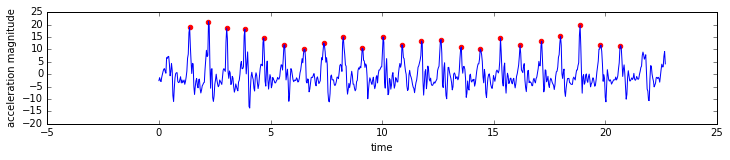

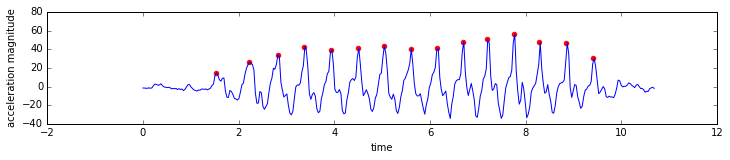

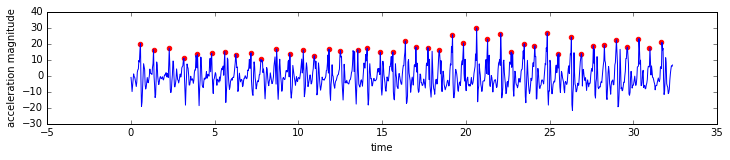

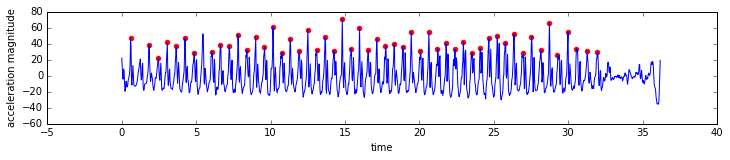

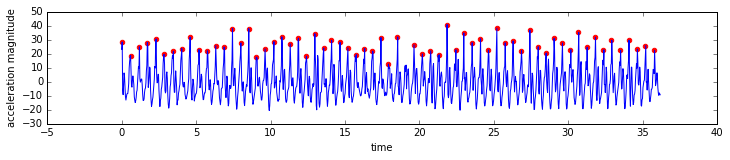

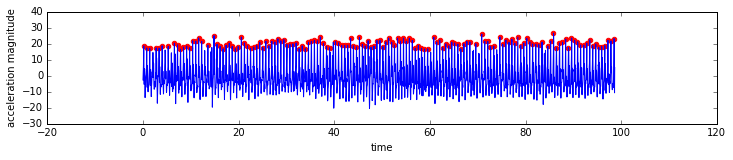

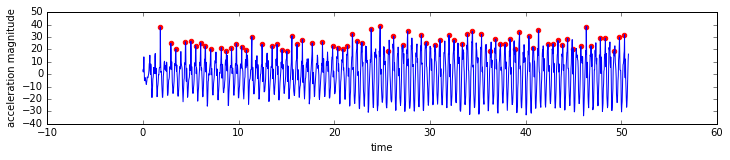

In [17]:
ind_1 = findpeaks(mag_1,plot=True)
ind_2 = findpeaks(mag_2,threshold=0.1,dist=10,plot=True)
ind_3 = findpeaks(mag_3,threshold=0.15,dist=15,plot=True)
ind_4 = findpeaks(mag_4,threshold=0.2,dist=15,plot=True)
ind_5 = findpeaks(mag_5,threshold=0.2,dist=15,plot=True)
ind_6 = findpeaks(mag_6,threshold=0.35,dist=15,plot=True)
ind_7 = findpeaks(mag_7,threshold=0.25,dist=15,plot=True)

### Comparing the steps of different people

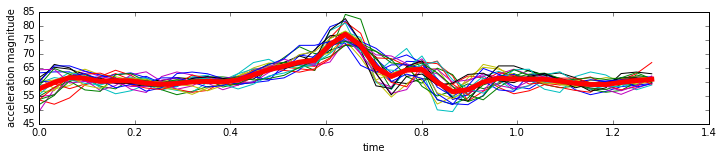

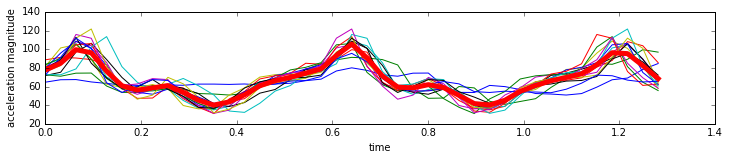

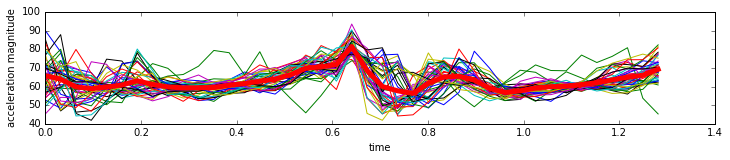

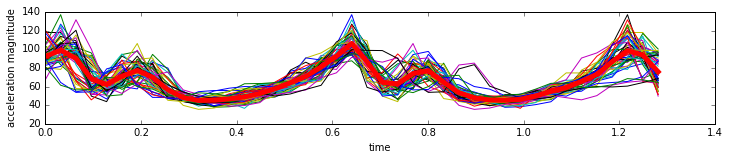

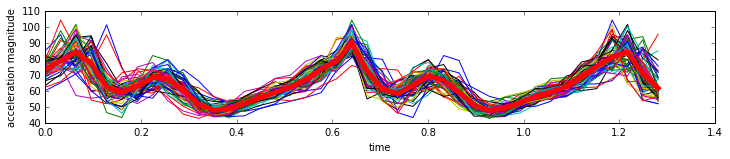

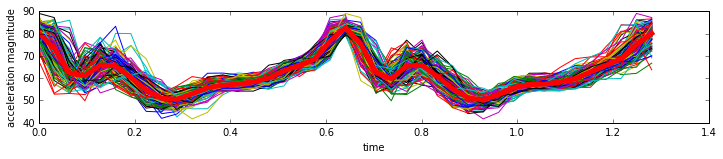

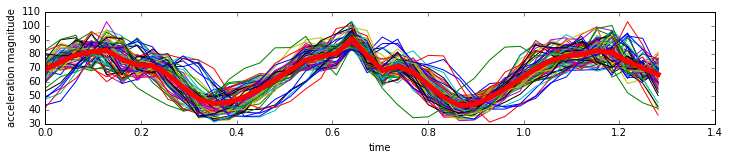

In [19]:
steps_1,mean_1 = alignsteps(ind_1,mag_1,plot=True)
steps_2,mean_2 = alignsteps(ind_2,mag_2,plot=True)
steps_3,mean_3 = alignsteps(ind_3,mag_3,plot=True)
steps_4,mean_4 = alignsteps(ind_4,mag_4,plot=True)
steps_5,mean_5 = alignsteps(ind_5,mag_5,plot=True)
steps_6,mean_6 = alignsteps(ind_6,mag_6,plot=True)
steps_7,mean_7 = alignsteps(ind_7,mag_7,plot=True)

Comparing the acceleration magnitude from the different people, there are a few observations that can be made. In general there is a main peak in the center of the graph that represents a step. There will also be a lower peak to the right of the main peak. This lower peak can be quite pronounced for some gaits but rather flat in others. For example, the 4th to 6th plots show a distinct lower peak but the 1st, 2nd and 7th plots have rather flat peaks. 

There are also differences at the start of the plots. For example, the 1st and 3rd plots show that the acceleration magnitude start off flat whereas the rest of the plots show that the acceleration magnitude start with a peak. Those peaks are likely to be the peaks from the previous step. Therefore, those people are likely to have a faster pace than the 1st or 3rd person because we can observe the previous step in the 1.3 second time interval. Similarly for the end of the plots, we can observe some of the people taking the next step. For example, in the 4th and 5th plots, the next peak appears at the end of the plot which indicates that the person is taking the next step. From the plots, we can also notice that some people's gaits are very similar like the 4th and 5th person.

Therefore, a person's gait could potentially be chracterized by 1) their pace which can be measured by the time interval between 2 peaks and 2) the time interval between the main peak and the lower peak as well as the ratio between the magnitude of the 2 peaks.

### Plotting the prinicipal component directions

In [20]:
eigenval = {}
eigenvec = {}
for i in range(1,num_data+1):
    eigenval[i], eigenvec[i] = dopca(vars()['steps_' + str(i)],vars()['mean_' + str(i)])

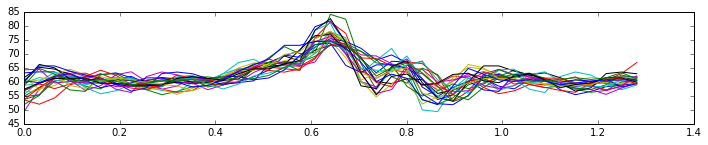

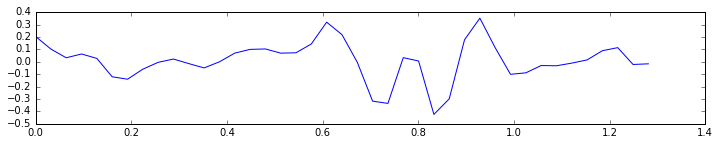

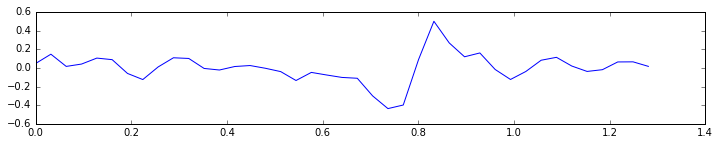

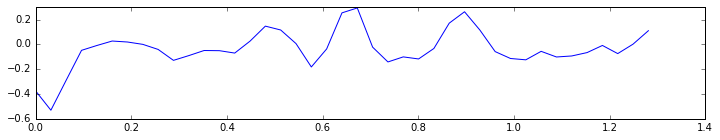

In [21]:
plotPC(steps_1,eigenvec[1],3)

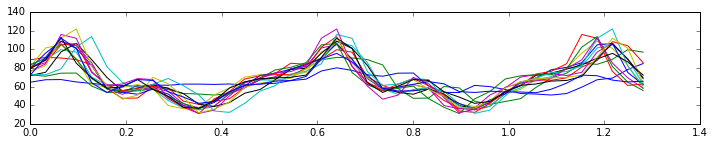

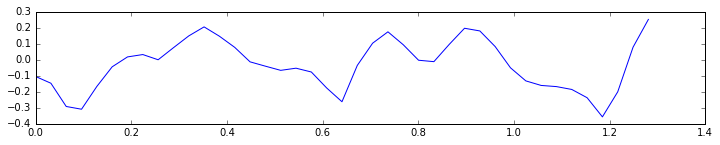

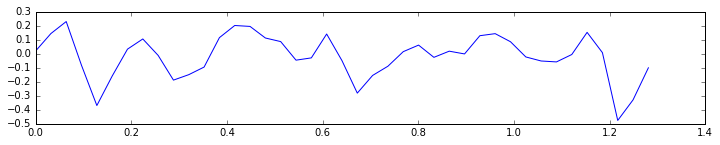

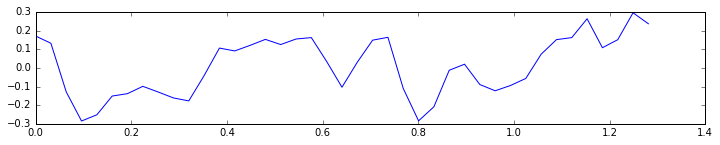

In [22]:
plotPC(steps_2,eigenvec[2],3)

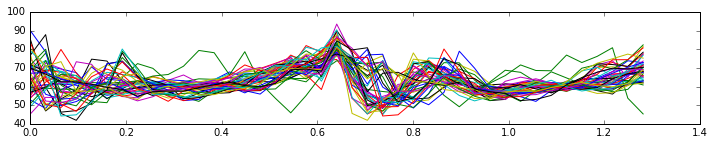

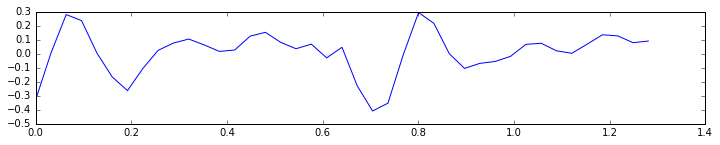

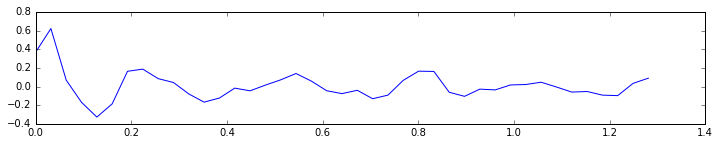

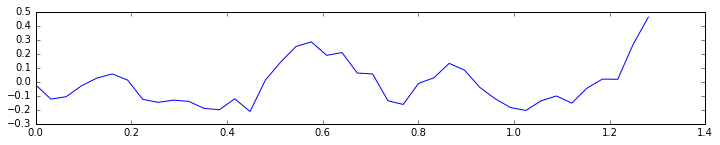

In [23]:
plotPC(steps_3,eigenvec[3],3)

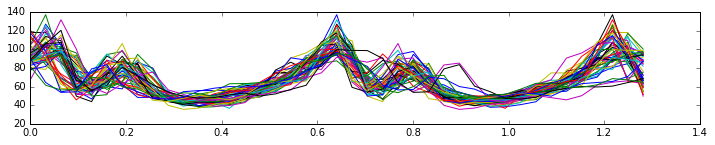

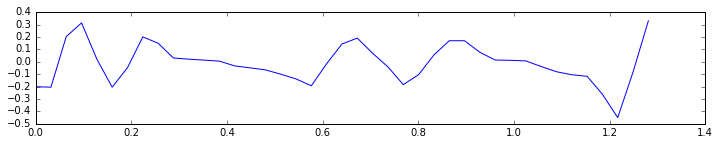

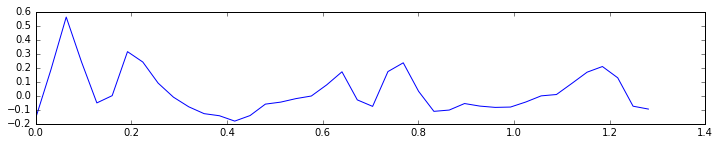

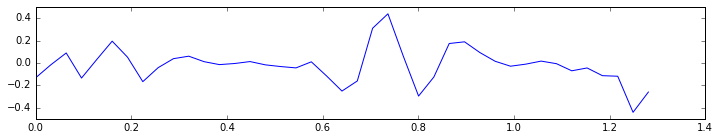

In [24]:
plotPC(steps_4,eigenvec[4],3)

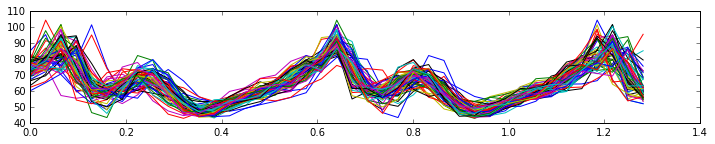

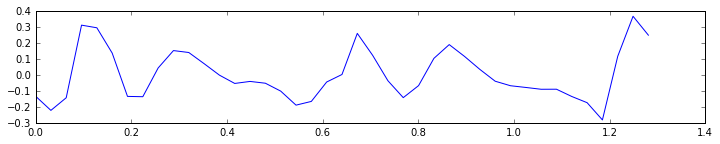

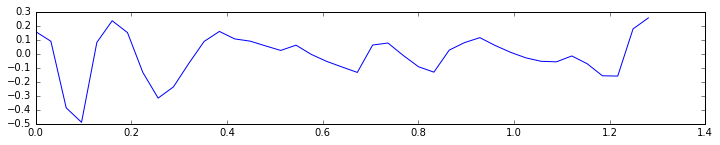

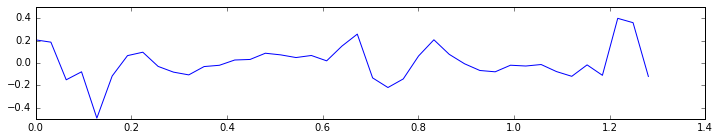

In [25]:
plotPC(steps_5,eigenvec[5],3)

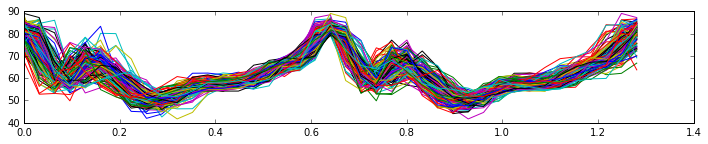

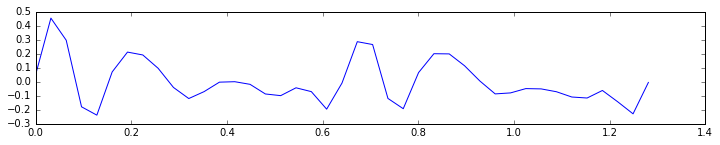

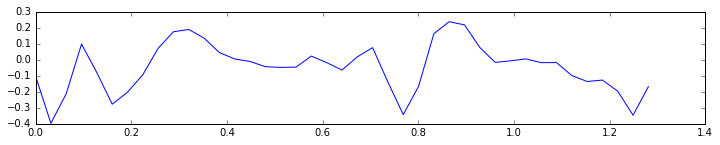

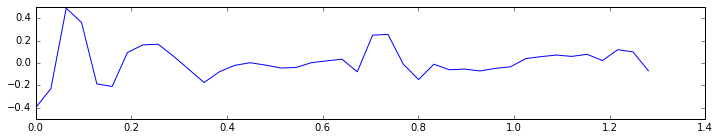

In [26]:
plotPC(steps_6,eigenvec[6],3)

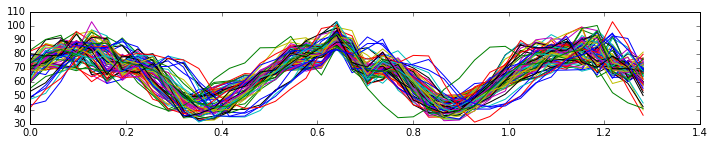

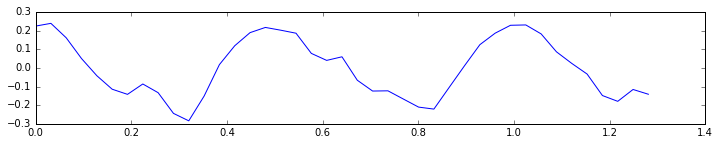

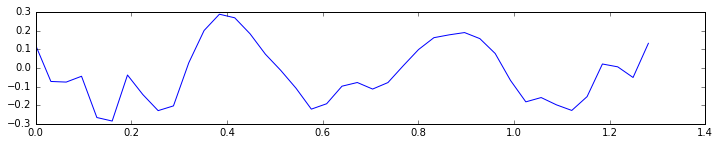

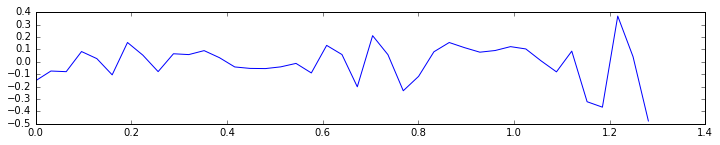

In [91]:
plotPC(steps_7,eigenvec[7],3)

The first eigenvector represents the direction / basis that captures the greatest variability in the data. Therefore, we can see that in general the first eigenvector has a shape that follows the plot of the acceleration magnitude (although the eigenvector may be out of phase with the original magnitude).

In [92]:
pc1 = np.array([i[:,0].real for i in eigenvec.values()])
np.dot(pc1,pc1.T).round(3)

array([[ 1.   , -0.253,  0.195, -0.157, -0.202, -0.278,  0.423],
       [-0.253,  1.   , -0.338,  0.275,  0.318,  0.083, -0.312],
       [ 0.195, -0.338,  1.   ,  0.013, -0.003, -0.243,  0.018],
       [-0.157,  0.275,  0.013,  1.   ,  0.46 ,  0.256, -0.055],
       [-0.202,  0.318, -0.003,  0.46 ,  1.   , -0.121, -0.425],
       [-0.278,  0.083, -0.243,  0.256, -0.121,  1.   ,  0.012],
       [ 0.423, -0.312,  0.018, -0.055, -0.425,  0.012,  1.   ]])

From the previous plots, we see that plots 4 and 5 show very similar gaits. Hence, we would expect that the first eigenvectors to look similar as well. Looking at the plots of the first eigenvectors, we do see that the general shape of the eigenvectors look similar. Using the inner product of the vectors as a measure of 'distance', the inner product of the first eigenvector of the 4th and 5th person is 0.46. This means the the 2 eigenvectors are not quite close to each other even though they look similar. 

In [30]:
stack_steps = []
for i in range(1,num_data+1):
    stack_steps.append(vars()['steps_'+str(i)])
    
findDist(stack_steps,0,6,plot=True) # compare the 7th test set against the training set

array([[ 1.   , -0.376, -0.281,  0.024, -0.137,  0.454, -0.011, -0.929],
       [-0.376,  1.   ,  0.324, -0.292,  0.1  , -0.289, -0.311,  0.356],
       [-0.281,  0.324,  1.   , -0.328,  0.096, -0.337,  0.007,  0.449],
       [ 0.024, -0.292, -0.328,  1.   ,  0.112, -0.023,  0.064, -0.048],
       [-0.137,  0.1  ,  0.096,  0.112,  1.   , -0.46 , -0.082,  0.105],
       [ 0.454, -0.289, -0.337, -0.023, -0.46 ,  1.   , -0.081, -0.418],
       [-0.011, -0.311,  0.007,  0.064, -0.082, -0.081,  1.   , -0.014],
       [-0.929,  0.356,  0.449, -0.048,  0.105, -0.418, -0.014,  1.   ]])

By computing the inner product as a measure of distance, the unknown gait can be identified by find the inner product with the largest absolute value. 

### Reduce dimension of data

#### Stack all the steps together

In [31]:
all_steps = steps_1
for i in range(2,num_data+1):
    all_steps = np.vstack((all_steps,vars()['steps_'+str(i)]))
    
all_steps_mean = np.array([np.mean(all_steps,axis=0)]).T

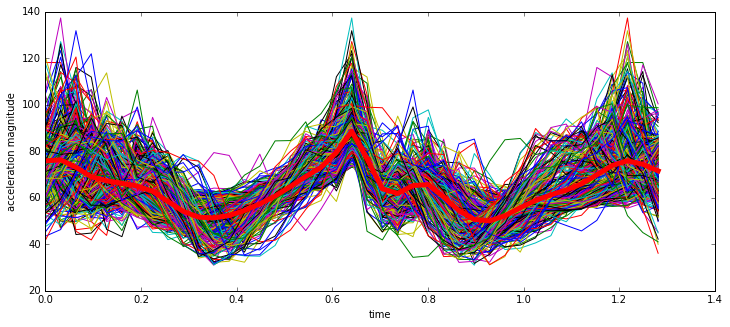

In [32]:
t = np.linspace(0,41.0/sampling_freq,41)
plt.figure(figsize=[12,5])
for i in all_steps:
    plt.plot(t,i)
plt.plot(t,all_steps_mean,color='r',linewidth=5)
plt.xlabel('time')
plt.ylabel('acceleration magnitude')

#### Perform PCA on all the steps

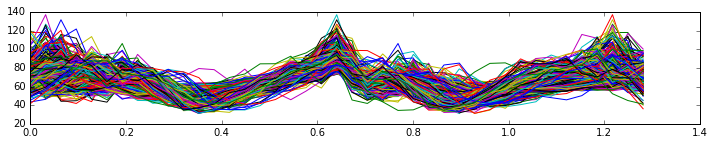

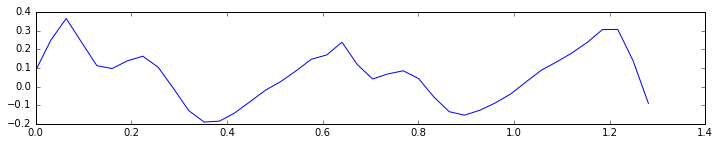

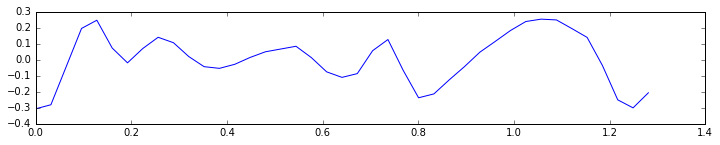

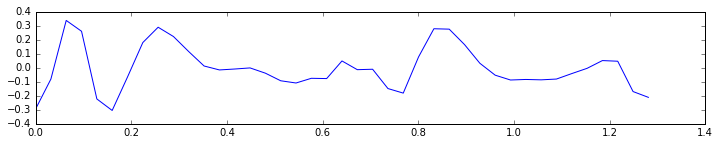

In [34]:
eigenvalue_all, eigenvector_all = dopca(all_steps,all_steps_mean)
plt.figure(figsize=[12,2])
plotPC(all_steps,eigenvector_all,3)

#### Reduce to 3D space and plot

In [37]:
acc_3d = {}
W = eigenvector_all[0:3] # first 3 principal directions
for i in range(1,num_data+1):
    steps = vars()['steps_'+str(i)]
    mean_steps = vars()['mean_'+str(i)]
    Y = np.dot(W,(steps.T - np.tile(mean_steps,(1,len(steps))))) # project data onto 3D space
    acc_3d[i] = Y.real.T

#### Compare 1st and 4th gaits

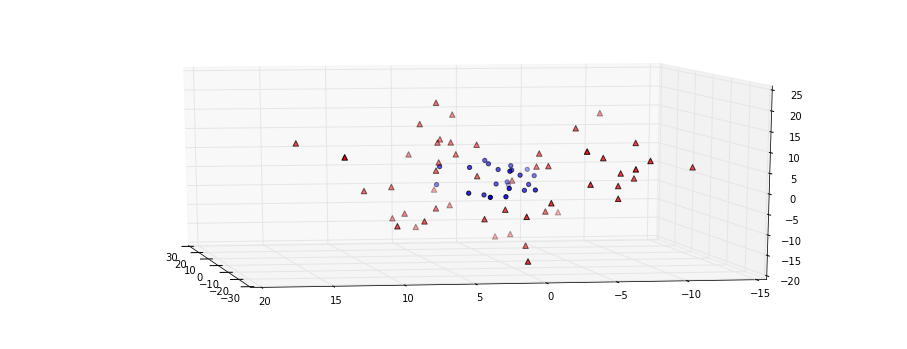

In [38]:
fig = plt.figure(figsize=[16,6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(acc_3d[1][:,0], acc_3d[1][:,1], acc_3d[1][:,2], zdir='z', s=70, c='b', marker='.')
ax.scatter(acc_3d[4][:,0], acc_3d[4][:,1], acc_3d[4][:,2], zdir='z', s=30, c='r', marker='^')
ax.azim = 170
ax.elev = 10

#### Compare 4th and 5th gaits

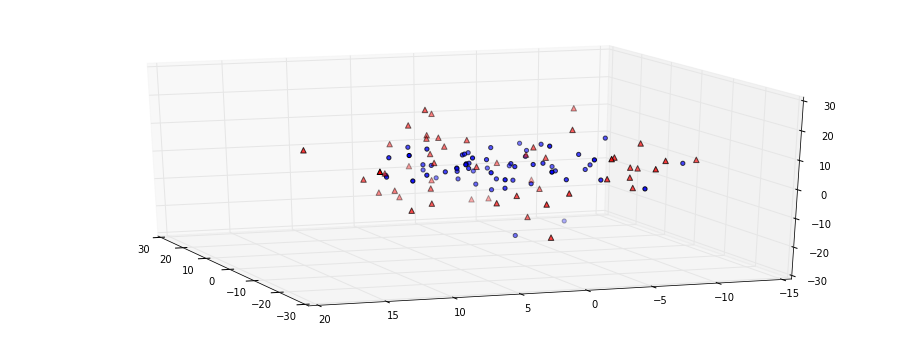

In [39]:
fig = plt.figure(figsize=[16,6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(acc_3d[5][:,0], acc_3d[5][:,1], acc_3d[5][:,2], zdir='z', s=70, c='b', marker='.')
ax.scatter(acc_3d[4][:,0], acc_3d[4][:,1], acc_3d[4][:,2], zdir='z', s=30, c='r', marker='^')
ax.azim = 160
ax.elev = 20

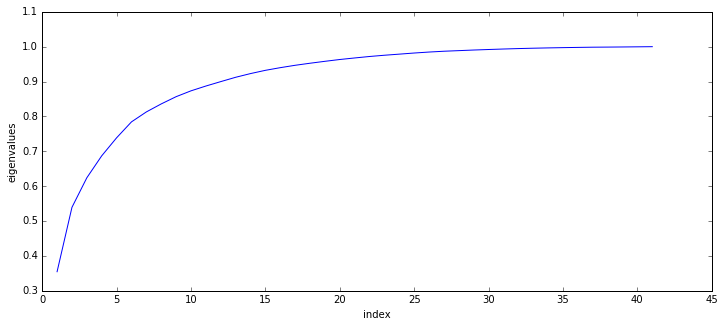

array([ 0.35472769,  0.53936366,  0.62410793,  0.68703989,  0.73869013,
        0.78437481,  0.81291608,  0.83588308,  0.85662074,  0.87337921,
        0.88713785,  0.89982738,  0.91221918,  0.92286296,  0.93218208,
        0.93982298,  0.94663208,  0.95252742,  0.95802921,  0.96320759,
        0.96764293,  0.97186358,  0.97543666,  0.97859824,  0.98180181,
        0.98460556,  0.98692752,  0.98864289,  0.99039123,  0.991893  ,
        0.99329472,  0.99455146,  0.99559519,  0.99647898,  0.99724429,
        0.99791975,  0.99850535,  0.99880201,  0.99915604,  0.99956836,  1.        ])

In [41]:
cumulativeEigen(eigenvalue_all)

The data in the reduced 3D space does not seem to separate clearly into different clusters, hence it will be difficult to classify the gaits in 3D space. This could be because the first 3 principal components only capture 62% of the variability. Hence, much of the data is lost when projected onto 3D space.

### Classification based on the 3 features

We can also try to classify the gaits based on the 3 potential features mentioned earlier.

1) time interval between 2 main peaks

2) time interval between the main peak and the lower peak

3) ratio between the magnitude of the main and lower peaks

In [42]:
def getFeatures(indexes,mag):
    buffersize = 16
    j = 0
    interval = [] 
    lowpeak = [] 
    pace = []
    for i in indexes:
        tmp = mag[i:i+buffersize] # extract the segment with the lower peak
        tmp = tmp - np.mean(tmp)
        index = peakutils.peak.indexes(tmp, thres=0, min_dist=2) # find the lower peak
        if len(index) != 0: # make sure the index is not empty
            if 1.0*tmp[0]/tmp[index[0]] < 30: # to remove some outliers
                interval.append(1.0*index[0]/sampling_freq) # feature 2
                lowpeak.append(1.0*tmp[0]/tmp[index[0]]) # feature 3
                pace.append(1.0*(indexes[j+1] - indexes[j])/sampling_freq) # feature 1

        j = j + 1
        if j == len(indexes) - 1:
            break
    
    return zip(interval,lowpeak,pace)

In [45]:
features = []
for i in range(1,num_data+1):
    features.append(getFeatures(vars()['ind_'+str(i)],vars()['mag_'+str(i)]))

#### Plot histograms of features

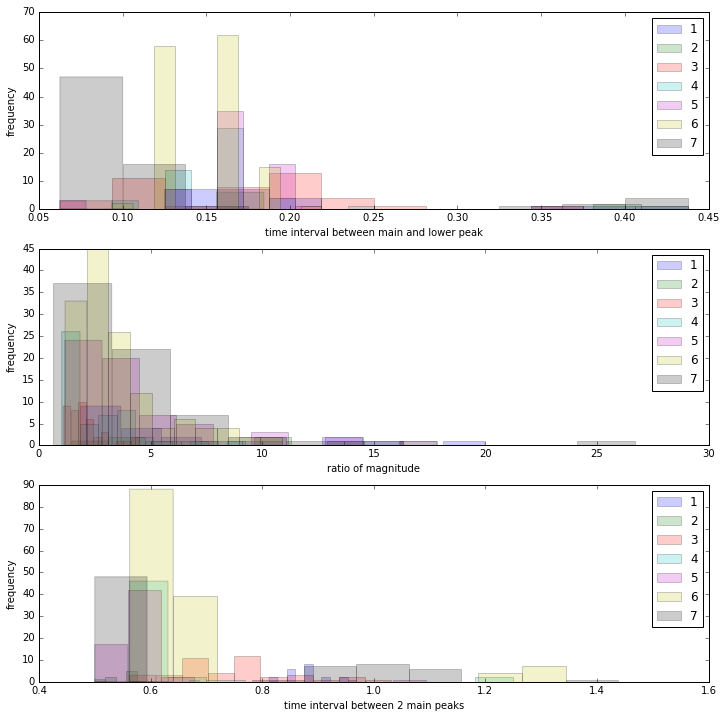

In [47]:
plt.figure(figsize=[12,12])
for i in range(3):
    plt.subplot(3,1,i+1)
    if i == 0:
        plt.xlabel('time interval between main and lower peak')
        plt.ylabel('frequency')
    if i == 1:
        plt.xlabel('ratio of magnitude')
        plt.ylabel('frequency')
    if i == 2:
        plt.xlabel('time interval between 2 main peaks')
        plt.ylabel('frequency')
    for j in range(num_data):
        tmp = [tmp1[i] for tmp1 in features[j]]
        plt.hist(tmp,alpha=0.2,label=str(j+1))
        plt.legend()

From the histograms, there does not seem to be a clear separation of the different gaits based on these features because all the histograms seem to be clustered into the same region. 

#### Plot pairs of features

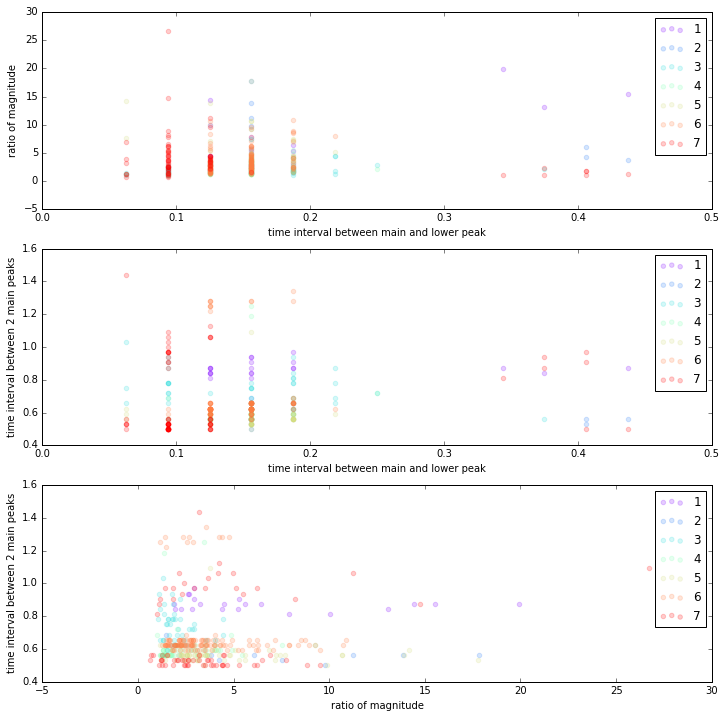

In [48]:
colors = cm.rainbow(np.linspace(0, 1, num_data))
plt.figure(figsize=[12,12])
g = 1
for i,k in zip([0,0,1],[1,2,2]):
    plt.subplot(3,1,g)
    if g == 1:
        plt.xlabel('time interval between main and lower peak')
        plt.ylabel('ratio of magnitude')
    if g == 2:
        plt.xlabel('time interval between main and lower peak')
        plt.ylabel('time interval between 2 main peaks')
    if g == 3:
        plt.xlabel('ratio of magnitude')
        plt.ylabel('time interval between 2 main peaks')
    for j in range(num_data):
        
        tmp = [tmp1[i] for tmp1 in features[j]]
        tmp2 = [tmp1[k] for tmp1 in features[j]]
        plt.scatter(tmp,tmp2,alpha=0.2,color=colors[j],label=str(j+1))
        plt.legend()
    g += 1


Similarly the scatter plots of pairs of features does not show any clear separation of the different gaits. Overall, it seems like these features are good at classifying the different gait patterns.